In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms,models,datasets
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

# 数据读取与预处理操作

In [2]:
data_dir = './cell_data/'
train_dir = data_dir + 'train'
valid_dir = data_dir + 'valid'

# 制作数据源

In [3]:
data_transforms ={
    'train':transforms.Compose([transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
                               transforms.CenterCrop(224),#从中心开始裁剪
                               transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转
                               transforms.RandomVerticalFlip(p=0.5),#垂直
                               transforms.ColorJitter(brightness=0.2,contrast=0.1,saturation=0.1,hue=0.1),#亮度/对比度/饱和度/色相
                               transforms.RandomGrayscale(p=0.025),#概率转换成灰度，彩色就是R=G=B
                               transforms.ToTensor(),#
                               transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])#均值/标准差
                               ]),
    'valid':transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                               ]),
    
}

In [4]:
batch_size = 8
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','valid']}#与数据存放格式对应
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True) for x in ['train','valid']}
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','valid']}
class_names = image_datasets['train'].classes

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 19260
     Root location: ./cell_data/train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=(-45, 45), resample=False, expand=False)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 4817
     Root location: ./cell_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      

In [6]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x21b869e5888>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x21b8535dd48>}

In [7]:
dataset_sizes

{'train': 19260, 'valid': 4817}

In [8]:
class_names

['dc', 'js', 'mj1', 'xs']

# 读取标签对应的实际名字

In [9]:
with open('class_names.json','r') as f:
    cell_names = json.load(f)

In [10]:
 cell_names 

{'dc': 'dichong', 'js': 'junsi', 'mj1': 'danbaomeijun', 'xs': 'xiansuoxibao'}

# 展示数据

In [11]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()#使用squeeze()函数将第一维去掉
    image = image.transpose(1,2,0)#tensor中C-H-W =》正常数据H-W-C
    image = image*np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))
    image = image.clip(0,1)#约束到0-1
    
    return image

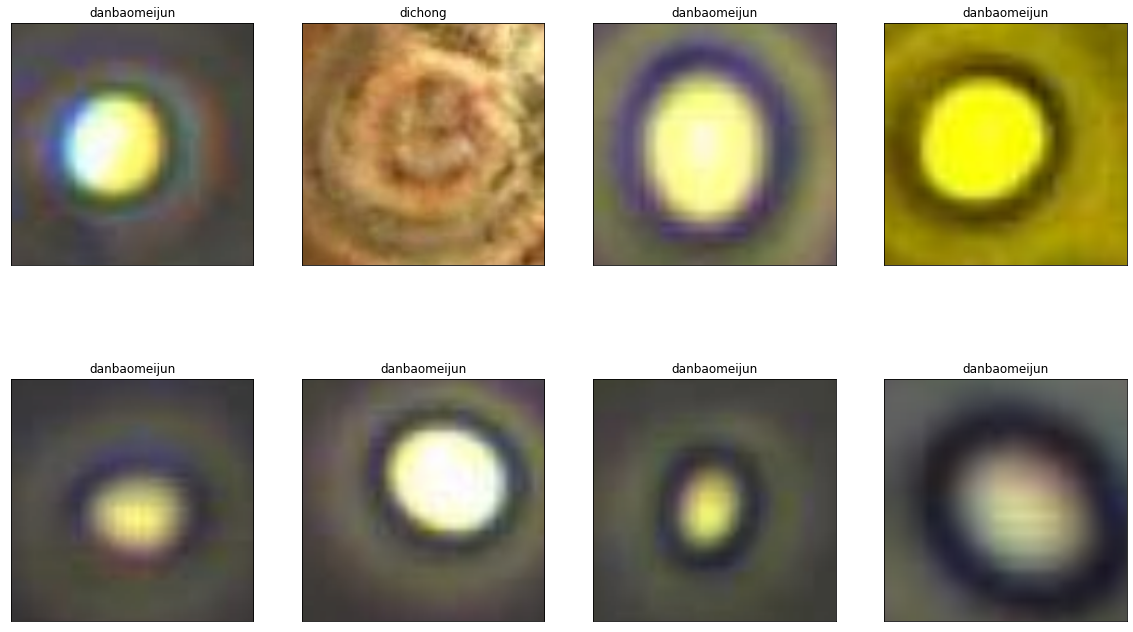

In [12]:
fig = plt.figure(figsize=(20,12))
columns = 4
rows = 2

dataiter = iter(dataloaders['valid'])
inputs,classes = dataiter.next()

for idx in range(columns*rows):
    ax  = fig.add_subplot(rows,columns,idx+1,xticks=[],yticks=[])
    ax.set_title(cell_names[str(class_names[classes[idx]])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

# 加载预训练模型

In [13]:
model_name = 'resnet'
feature_extract = True

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not availabel. Training on CPU.....')
else:
    print('CUDA is availabel. Training on GPU.....')

device = torch.device("cuda:0" if train_on_gpu else "cpu")


CUDA is availabel. Training on GPU.....


In [14]:
def set_parameter_requires_grad(model,feature_extracting):
    if feature_extracting:
        for para in model.parameters():
            para.requires_grad = False

In [15]:
model_ft = models.resnet152()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
def initialize_model(model_name,num_classes,feature_extract,use_pretrained=True):
    model_ft =None
    input_size = 0
    #不同模型初始化稍有不同
    if model_name == "resnet":
        model_ft = models.resnet152(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs,4),nn.LogSoftmax(dim=1))    #修改4
        input_size = 224
    
    elif mode_name == "alexnet":
        model_ft = models.alexnet(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6]= nn.Linear(num_ftrs,num_classes)       
        input_size = 224
     
    elif model_name == "vgg":
        model_ft = models.vgg16(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6]= nn.Linear(num_ftrs,num_classes)       
        input_size = 224
        
    elif model_name =="squeezenet":
        model_ft = models.squeezenet1_0(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[1]= nn.Conv2d(512,num_classes,kernel_size=(1,1),stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
        
    elif model_name == "densenet":
        model_ft = models.densenet121(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier= nn.Linear(num_ftrs,num_classes)       
        input_size = 224
        
    elif model_name == "inception":
        model_ft = models.inception_v3(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs = model_ft.Auxlogits.fc.in_features
        model_ft.Auxlogits.fc = nn.Linear(num_ftrs,num_classes)
        
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)    
        input_size = 299
    else:
        print("Invalid model name,exiting...")
        exit()
    
    return model_ft,input_size      

# 设置哪些层需要训练

In [22]:
model_ft,input_size = initialize_model(model_name,4,feature_extract,use_pretrained=True)

model_ft = model_ft.to(device)

filename = 'checkpoints.pth'

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias


In [18]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 优化器设置

In [27]:
optimizer_ft = optim.Adam(params_to_update,lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)#学习率每7个epochs衰减为原来的1/10
criterion = nn.NLLLoss()#别拉下括号
#criterion = nn.CrossEntropyLoss()#修正，最后一层已经LogSoftmax了，不能用CrossEntropyLoss，CrossEntropyLoss相当于LogSoftmax和NLLLoss整合

# 训练函数

In [28]:
def train_model(model,dataloaders,criterion,optimizer,num_epochs=25,is_inception=False,filename=filename):
    since = time.time()
    best_acc = 0
    
    model.to(device)
    
    val_acc_history = []
    train_acc_history =[]
    train_loss = []
    valid_loss = []
    LRs = [optimizer.param_groups[0]['lr']]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*20)
        
        #训练和验证
        for phase in ['train','valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            #把数据都取个遍
            for inputs,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #清零
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase =='train'):
                    if is_inception and phase == 'train':
                        outputs,aux_outputs = model(inputs)
                        loss1 = criterion(outputs,labels)
                        loss2 = criterion(aux_outputs,labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行这里
                        outputs= model(inputs)
                        loss =  criterion(outputs,labels)
                        
                    _,preds = torch.max(outputs,1)
                    
                    #训练阶段更新权重
                    if phase =='train':
                        loss.backward()
                        optimizer.step()
                        
                #计算损失
                running_loss +=loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
            time_elapsed = time.time() -since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            
            #得到最好的那次模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                    'state_dict':model.state_dict(),
                    'best_acc':best_acc,
                    'optimizer':optimizer.state_dict(),
                }
                torch.save(state,filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_loss.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss.append(epoch_loss)
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
        
    time_elapsed = time.time() -since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    #训练完后用最好的一次当作模型最终结果
    model.load_state_dict(best_model_wts)
    return model,val_acc_history,train_acc_history,valid_loss,train_loss,LRs
                

# 开始训练

In [ ]:
model_ft,val_acc_history,train_acc_history,valid_losses,train_losses,LRs = train_model(model_ft,dataloaders,criterion,optimizer_ft,20,False,filename)

Epoch 0/19
--------------------


# 对所有参数训练

In [47]:
for param in model_ft.parameters():
    param.requires_grad = True;
#再继续训练所有参数，学习率调小
optimizer = optim.Adam(params_to_update,lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)
#损失函数
criterion = nn.CrossEntropyLoss()#修正

In [48]:
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [49]:
model_ft,val_acc_history,train_acc_history,valid_losses,train_losses,LRs = train_model(model_ft,dataloaders,criterion,optimizer_ft,10,False,filename)

Epoch 0/9
--------------------
Time elapsed 21m 38s
train Loss: 0.3397 Acc: 0.9863
Time elapsed 23m 19s
valid Loss: 16.6579 Acc: 0.8970
Optimizer learning rate : 0.0001000

Epoch 1/9
--------------------
Time elapsed 44m 58s
train Loss: 0.3021 Acc: 0.9871
Time elapsed 46m 39s
valid Loss: 33.4827 Acc: 0.8661
Optimizer learning rate : 0.0000010

Epoch 2/9
--------------------
Time elapsed 68m 18s
train Loss: 0.3344 Acc: 0.9867
Time elapsed 69m 59s
valid Loss: 7.8916 Acc: 0.9224
Optimizer learning rate : 0.0010000

Epoch 3/9
--------------------
Time elapsed 91m 41s
train Loss: 0.3197 Acc: 0.9868
Time elapsed 93m 22s
valid Loss: 49.9157 Acc: 0.8729
Optimizer learning rate : 0.0000000

Epoch 4/9
--------------------
Time elapsed 115m 6s
train Loss: 0.3034 Acc: 0.9866
Time elapsed 116m 47s
valid Loss: 6.7029 Acc: 0.8993
Optimizer learning rate : 0.0100000

Epoch 5/9
--------------------
Time elapsed 138m 32s
train Loss: 0.3303 Acc: 0.9868
Time elapsed 140m 13s
valid Loss: 11.2404 Acc: 0.898

# 预测

In [50]:
model_ft,input_size = initialize_model(model_name,4,feature_extract,use_pretrained=True)
#GPU模式
model_ft = model_ft.to(device)
#保存文件的名称
filename = 'checkpoints.pth'
#加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [51]:
def process_image(image_path):
    #读取测试数据
    img = Image.open(image_path)
    #Resize,thumbnail方法只能进行缩小，所以进行了判断
    if img.size[0]>img.size[1]:
         img.thumbnail((10000,256))
    else:
         img.thumbnail((256,10000))
    #crop操作
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin,bottom_margin,right_margin,top_margin))
    #相同的预处理方法
    img = np.array(img)/255
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    img = (img-mean)/std
    
    #注意颜色通道应该放在第一个位置
    img = img.transpose((2,0,1))#原数据H-W-C==》pytorch里的C-H-W
    
    return img#得到dataloader数据类型

In [52]:
def imshow(image,ax=None,title=None):
    if ax is None:
        fig,ax = plt.subplots()
    #颜色通道还原
    image = np.array(image).transpose((1,2,0))
    #预处理还原
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    image = std*image + mean
    ax.imshow(image)
    ax.set_title(title)
    return ax

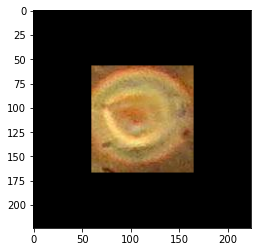

In [53]:
image_path = 'test2.jpg'
img = process_image(image_path)
imshow(img)

In [54]:
#得到一个batch的测试数据
dataiter = iter(dataloaders['valid'])
images,labels = dataiter.next()
model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

In [55]:
output.shape

torch.Size([8, 4])

# 得到概率最大的那个

In [56]:
_,preds_tensor = torch.max(output,1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

array([2, 2, 2, 0, 2, 2, 2, 2], dtype=int64)

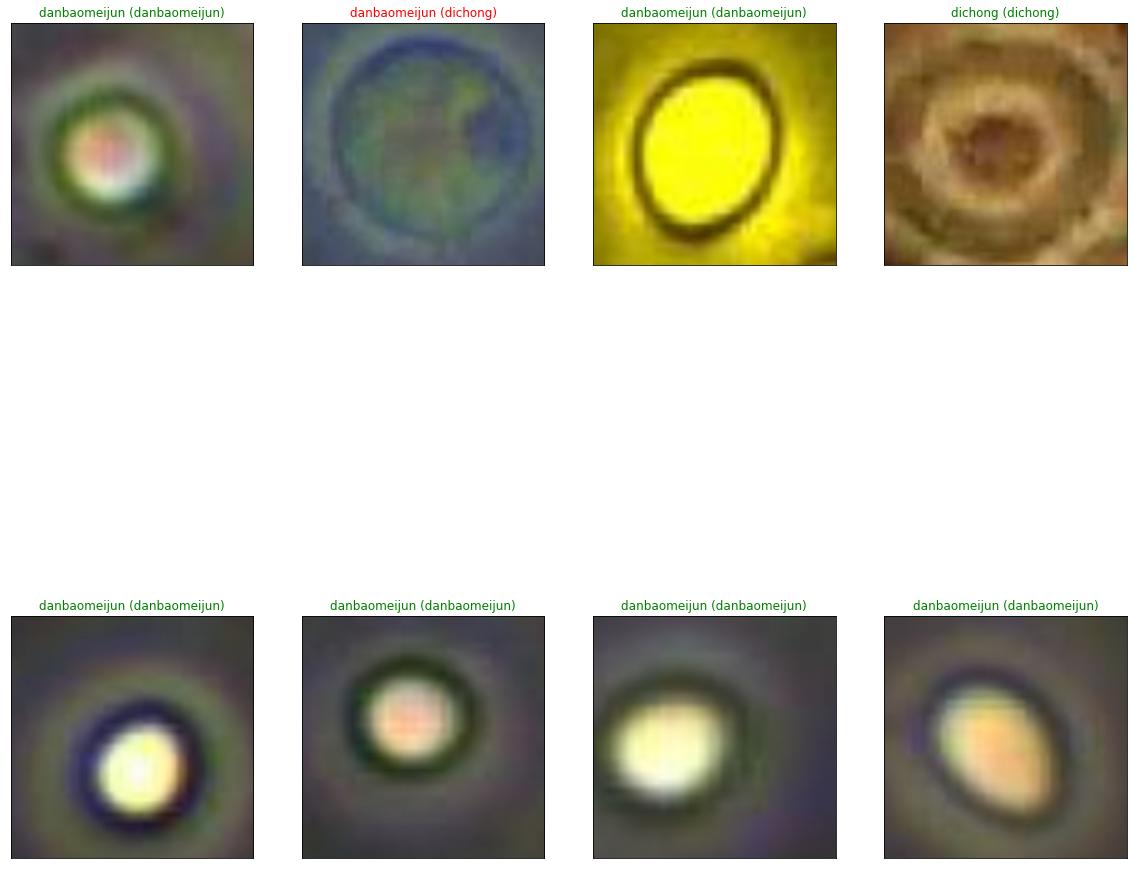

In [57]:
fig = plt.figure(figsize=(20,20))
cilomns =4
rows = 2
for idx in range(columns*rows):
    ax = fig.add_subplot(rows,columns,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cell_names[class_names[preds[idx]]],cell_names[class_names[labels[idx].item()]]),
               color=("green" if class_names[preds[idx]]==class_names[labels[idx].item()] else "red"))             
plt.show()

In [58]:
for key,value in checkpoint['optimizer'].items():#state_dict optimizer  best_acc
    print(key,value,sep="   ")

state   {0: {'step': 55384, 'exp_avg': tensor([[-5.6052e-45, -5.6052e-45, -5.6052e-45,  ..., -5.6052e-45,
         -5.6052e-45, -5.6052e-45],
        [ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
          5.6052e-45,  5.6052e-45],
        [ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
          5.6052e-45,  5.6052e-45],
        [ 5.6052e-45,  5.6052e-45,  5.6052e-45,  ...,  5.6052e-45,
          5.6052e-45,  5.6052e-45]], device='cuda:0'), 'exp_avg_sq': tensor([[3.6712e-07, 1.5038e-07, 5.2125e-07,  ..., 8.4844e-08, 9.2550e-08,
         1.7932e-07],
        [1.4318e-07, 1.7362e-08, 2.6704e-07,  ..., 2.5808e-08, 2.8409e-08,
         8.6356e-08],
        [2.8498e-07, 1.2354e-07, 4.3596e-07,  ..., 6.9580e-08, 6.7574e-08,
         1.5169e-07],
        [2.2200e-07, 4.3693e-08, 3.4810e-07,  ..., 4.1225e-08, 5.3071e-08,
         1.1387e-07]], device='cuda:0')}, 1: {'step': 55384, 'exp_avg': tensor([-5.6052e-45,  5.6052e-45,  5.6052e-45,  5.6052e-45], device='cuda:0'),

In [60]:
for key,value in checkpoint['state_dict'].items():#state_dict optimizer  best_acc
    if(value.dim()==0):
        print(key,value,sep="   ")
    else:
        print(key,len(value),sep="   ")

conv1.weight   64
bn1.weight   64
bn1.bias   64
bn1.running_mean   64
bn1.running_var   64
bn1.num_batches_tracked   tensor(19264, device='cuda:0')
layer1.0.conv1.weight   64
layer1.0.bn1.weight   64
layer1.0.bn1.bias   64
layer1.0.bn1.running_mean   64
layer1.0.bn1.running_var   64
layer1.0.bn1.num_batches_tracked   tensor(19264, device='cuda:0')
layer1.0.conv2.weight   64
layer1.0.bn2.weight   64
layer1.0.bn2.bias   64
layer1.0.bn2.running_mean   64
layer1.0.bn2.running_var   64
layer1.0.bn2.num_batches_tracked   tensor(19264, device='cuda:0')
layer1.0.conv3.weight   256
layer1.0.bn3.weight   256
layer1.0.bn3.bias   256
layer1.0.bn3.running_mean   256
layer1.0.bn3.running_var   256
layer1.0.bn3.num_batches_tracked   tensor(19264, device='cuda:0')
layer1.0.downsample.0.weight   256
layer1.0.downsample.1.weight   256
layer1.0.downsample.1.bias   256
layer1.0.downsample.1.running_mean   256
layer1.0.downsample.1.running_var   256
layer1.0.downsample.1.num_batches_tracked   tensor(19264,

In [61]:
print(checkpoint['best_acc'])
print(type(checkpoint)) 

tensor(0.9224, device='cuda:0', dtype=torch.float64)
<class 'dict'>


In [62]:
a=torch.tensor(7224, device='cuda:0')
a

tensor(7224, device='cuda:0')

In [63]:
torch.__version__

'1.6.0'

# pth/pt/pkl转onnx格式

In [64]:
model_ft,input_size = initialize_model('resnet',4,True,use_pretrained=True)
#保存文件的名称
filename = 'checkpoints.pth'
#加载模型
checkpoint = torch.load(filename)
model_ft.load_state_dict(checkpoint['state_dict'])
torch.save(model_ft, 'checkpoint.pt')

In [65]:
input = torch.randn(1, 3, 224, 224, device='cpu')
model = torch.load("checkpoint.pt")
torch.onnx.export(model, input, "checkpoint.onnx", verbose=True)

# batch_size=1
# input_shape = (1, 224, 224)  # 输入数据,改成自己的输入shape #renet
# example = torch.randn(batch_size, *input_shape)  # 生成张量
# export_onnx_file = "checkpoints.onnx"  # 目的ONNX文件名
# torch.onnx.export(model, example, export_onnx_file, verbose=True)

graph(%input.1 : Float(1:150528, 3:50176, 224:224, 224:1),
      %conv1.weight : Float(64:147, 3:49, 7:7, 7:1),
      %bn1.weight : Float(64:1),
      %bn1.bias : Float(64:1),
      %bn1.running_mean : Float(64:1),
      %bn1.running_var : Float(64:1),
      %layer1.0.conv1.weight : Float(64:64, 64:1, 1:1, 1:1),
      %layer1.0.bn1.weight : Float(64:1),
      %layer1.0.bn1.bias : Float(64:1),
      %layer1.0.bn1.running_mean : Float(64:1),
      %layer1.0.bn1.running_var : Float(64:1),
      %layer1.0.conv2.weight : Float(64:576, 64:9, 3:3, 3:1),
      %layer1.0.bn2.weight : Float(64:1),
      %layer1.0.bn2.bias : Float(64:1),
      %layer1.0.bn2.running_mean : Float(64:1),
      %layer1.0.bn2.running_var : Float(64:1),
      %layer1.0.conv3.weight : Float(256:64, 64:1, 1:1, 1:1),
      %layer1.0.bn3.weight : Float(256:1),
      %layer1.0.bn3.bias : Float(256:1),
      %layer1.0.bn3.running_mean : Float(256:1),
      %layer1.0.bn3.running_var : Float(256:1),
      %layer1.0.downsample.

# opencv预测

In [ ]:
import cv2 as cv
import numpy as np

net = cv.dnn.readNetFromONNX("checkpoint.onnx")
image = cv.imread("test5.jpg")
#gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
cv.imshow("input", image)
blob = cv.dnn.blobFromImage(image, 1.0/225, (224, 224), (0.485,0.456,0.406),False,False)
print(blob.shape)
net.setInput(blob)
result = net.forward()
pred_label = np.argmax(result, 1)
print("predit label : %d"%pred_label)
cv.waitKey(0)
cv.destroyAllWindows()